<a href="https://colab.research.google.com/github/michaelCastillo/DeepLearningCoursera/blob/master/Copy_of_LSTM_HH_model_27_02_oficial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM HH-model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cd drive


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [3]:
#To be used in case of new environment
#!pip install tensorflow==2.5.0
#!pip install pandas
!pip install neuron
%cd "/content/drive/Shareddrives/ProjectoTesis/Code/Tesis_rrnn_neurosiml/src"

     |████████████████████████████████| 12.6 MB 5.8 MB/s 
/content/drive/Shareddrives/ProjectoTesis/Code/Tesis_rrnn_neurosiml/src


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
from pandas import read_csv
import time

2.8.0


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    print(f"New shape: {series.shape}")
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Generating series


In [7]:
from utils.files import getFilenames, getValues
from utils.lstm_utils import combineTimeSeries, generateStimulationSignal, rescale,scale_stimTo_simulation, index_trim_simulation
def plot_series(time, series, format="-",figure = 1, title="", start=0, end=None):
    plt.figure(figure)
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    plt.grid(True)

filename="results/voltage/monophasic_pulse_train/voltage_amp_0.4_freq_0.4_fiberd_10_dist_100_tsiml_100_pw_0.2_step_0.01.csv"
simulation_df = read_csv(
    filename, header=0, parse_dates=[0], index_col=0)
simulationVm = simulation_df.values
values = getValues(filename)
simulationTime = float(values["tsiml"])
print(f"Values: {values}")
v_scaled, t_scaled = scale_stimTo_simulation(float(values["amp"]), float(values["freq"]), 10 , simulationTime, values["type_stimuli"], len(simulationVm))
print(f"Series size: {v_scaled.size} ~ simulation_time: {t_scaled.size}")
series_size = t_scaled.size
trainingSetProp = 0.6
simulation_df["stimuli_vm"] = v_scaled
print(simulation_df)
simulationVm = simulation_df[["stimuli_vm", "vm"]].to_numpy()
split_time = int(trainingSetProp*series_size)
time_train = t_scaled[:split_time]
x_train = simulationVm[:split_time]
time_valid = t_scaled[split_time:]
x_valid = simulationVm[split_time:]

print(f"time_train_size: {time_train.size} ~ x_tran_size: {x_train.size} ~  time_valid_s: {time_valid.size} ~ x_valid: {x_valid.size}")

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

2022-03-01 00:20:43,731 | INFO | Generating amp: 0.4,
                         freq: 0.4,
                         delay:10,
                         t_siml:100.0,
                         type_siml:monophasic_pulse_train,
                         scale:9999
          


Values: {'amp': 0.4, 'freq': 0.4, 'fiberd': 10.0, 'dist': 100.0, 'tsiml': 100.0, 'pw': 0.2, 'step': 0.01, 'type_stimuli': 'monophasic_pulse_train'}
Series size: 9999 ~ simulation_time: 9999
              vm  stimuli_vm
t                           
0.00  -77.300000         0.0
0.01  -77.319968         0.0
0.02  -77.336411         0.0
0.03  -77.351126         0.0
0.04  -77.364656         0.0
...          ...         ...
99.94 -80.445997         0.0
99.95 -80.449087         0.0
99.96 -80.452173         0.0
99.97 -80.455255         0.0
99.98 -80.458332         0.0

[9999 rows x 2 columns]
time_train_size: 5999 ~ x_tran_size: 11998 ~  time_valid_s: 4000 ~ x_valid: 8000


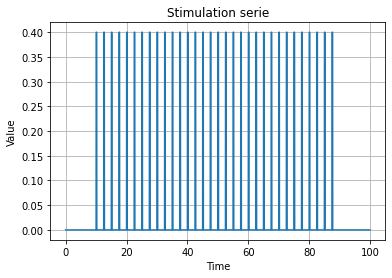

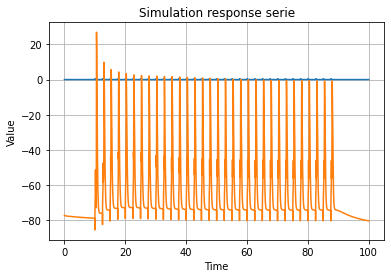

In [8]:
# Plotting the simulation scaled
plot_series(t_scaled, v_scaled, title="Stimulation serie", figure=1)
plot_series(t_scaled, simulationVm, title="Simulation response serie", figure=2)

## First attempt: LSTM univariate.
- Epochs: 100.
- window_size = 30.
- Using a fixed learning rate.
- Gradient descend.

In [36]:
start_time = time.time()
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=15,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 2]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
one_hundred_epochs_trainingtime_taken = time.time()-start_time

New shape: (5999, 2, 1)
Epoch 1/100
47/47 [==============================] - 5s 28ms/step - loss: 37.9828 - mae: 38.4761 - lr: 1.0000e-08
Epoch 2/100
47/47 [==============================] - 1s 27ms/step - loss: 36.6279 - mae: 37.1226 - lr: 1.1220e-08
Epoch 3/100
47/47 [==============================] - 1s 15ms/step - loss: 35.8822 - mae: 36.3794 - lr: 1.2589e-08
Epoch 4/100
47/47 [==============================] - 1s 16ms/step - loss: 35.3346 - mae: 35.8314 - lr: 1.4125e-08
Epoch 5/100
47/47 [==============================] - 1s 16ms/step - loss: 34.9278 - mae: 35.4231 - lr: 1.5849e-08
Epoch 6/100
47/47 [==============================] - 1s 16ms/step - loss: 34.6286 - mae: 35.1237 - lr: 1.7783e-08
Epoch 7/100
47/47 [==============================] - 1s 15ms/step - loss: 34.4005 - mae: 34.8982 - lr: 1.9953e-08
Epoch 8/100
47/47 [==============================] - 1s 16ms/step - loss: 34.2232 - mae: 34.7196 - lr: 2.2387e-08
Epoch 9/100
47/47 [==============================] - 1s 16ms/ste

(1e-08, 0.1, 0.0, 50.0)

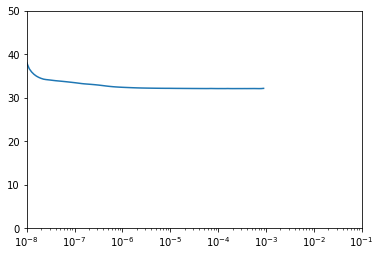

In [37]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 50])

series size: 19998
Time elapsed: 2.398738384246826s


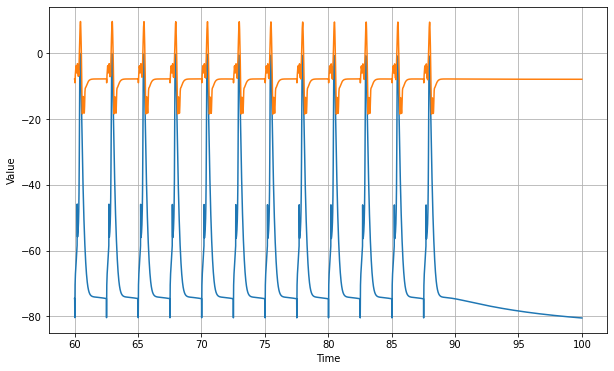

In [38]:
import time
start = time.time()
rnn_forecast = model_forecast(model, simulationVm[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
total= time.time() - start
print(f"series size: {simulationVm.size}")
print(f"Time elapsed: {total}s")
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid[:,-1])
plot_series(time_valid, rnn_forecast)

In [41]:
start_time = time.time()
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=15,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 2]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)
five_hundred_epochs_trainingtime_taken = time.time()-start_time

New shape: (5999, 2, 1)
Epoch 1/500
187/187 [==============================] - 4s 9ms/step - loss: 32.4634 - mae: 32.9604
Epoch 2/500
187/187 [==============================] - 2s 8ms/step - loss: 32.1395 - mae: 32.6375
Epoch 3/500
187/187 [==============================] - 2s 8ms/step - loss: 32.1078 - mae: 32.6057
Epoch 4/500
187/187 [==============================] - 2s 9ms/step - loss: 32.0936 - mae: 32.5913
Epoch 5/500
187/187 [==============================] - 2s 8ms/step - loss: 32.0855 - mae: 32.5831
Epoch 6/500
187/187 [==============================] - 2s 8ms/step - loss: 32.0790 - mae: 32.5764
Epoch 7/500
187/187 [==============================] - 2s 9ms/step - loss: 32.0759 - mae: 32.5732
Epoch 8/500
187/187 [==============================] - 2s 9ms/step - loss: 32.0727 - mae: 32.5699
Epoch 9/500
187/187 [==============================] - 2s 9ms/step - loss: 32.0699 - mae: 32.5671
Epoch 10/500
187/187 [==============================] - 2s 9ms/step - loss: 32.0680 - mae: 32.

KeyboardInterrupt: ignored

series size: 19998
Time elapsed: 4.434482574462891s
valid:  [[ 0.00000000e+00 -7.45415890e+01]
 [ 4.00000000e-01 -7.45485361e+01]
 [ 4.00000000e-01 -8.03478639e+01]
 [ 4.00000000e-01 -7.33985168e+01]
 [ 4.00000000e-01 -7.04049708e+01]
 [ 4.00000000e-01 -6.88438938e+01]
 [ 4.00000000e-01 -6.78091464e+01]
 [ 4.00000000e-01 -6.69838681e+01]
 [ 4.00000000e-01 -6.62568381e+01]
 [ 4.00000000e-01 -6.55851461e+01]
 [ 4.00000000e-01 -6.49481131e+01]
 [ 4.00000000e-01 -6.43331334e+01]
 [ 4.00000000e-01 -6.37306576e+01]
 [ 4.00000000e-01 -6.31323986e+01]
 [ 4.00000000e-01 -6.25306415e+01]
 [ 4.00000000e-01 -6.19178142e+01]
 [ 4.00000000e-01 -6.12860822e+01]
 [ 4.00000000e-01 -6.06269120e+01]
 [ 4.00000000e-01 -5.99305741e+01]
 [ 4.00000000e-01 -5.91855108e+01]
 [ 0.00000000e+00 -5.83774916e+01]
 [ 0.00000000e+00 -4.58504392e+01]
 [ 0.00000000e+00 -5.34529036e+01]
 [ 0.00000000e+00 -5.55032501e+01]
 [ 0.00000000e+00 -5.58071686e+01]
 [ 0.00000000e+00 -5.56013538e+01]
 [ 0.00000000e+00 -5.52084617e

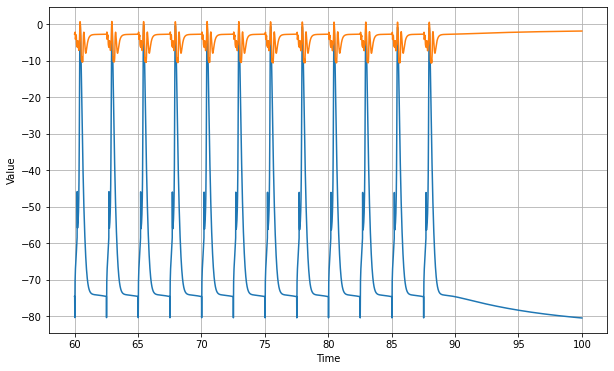

In [42]:
import time
start = time.time()
rnn_forecast = model_forecast(model, simulationVm[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
total= time.time() - start
print(f"series size: {simulationVm.size}")
print(f"Time elapsed: {total}s")
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid[:,-1])
plot_series(time_valid, rnn_forecast)
print(f"valid: ",x_valid[0:100])
print(f"forecast: ", rnn_forecast[0:100])
# Será que la convolución qye hace al principio pordría disminuir el tamaño de mis samplings ?

In [43]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

InvalidArgumentError: ignored

<Figure size 432x288 with 0 Axes>

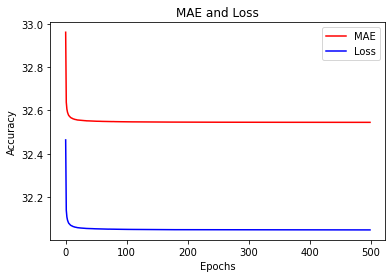

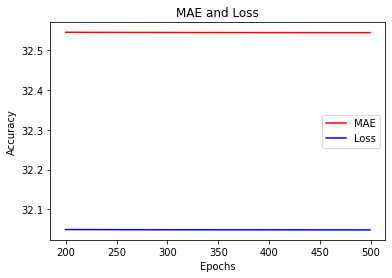

<Figure size 432x288 with 0 Axes>

In [44]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()